In [1]:
import pandas
import matplotlib.pyplot as plt

# Given the time a transfer took, amount transferred, number of transfers in the time period, and memory unit
# return bandwidth for that transfer in GB/s
def bandwidth_GB(elapsed_time, memory_amt, accesses, unit):
    MEMORY_UNITS = {"B":1,"KB":2**10,"MB":2**20,"GB":2**30,"TB":2**40}
    
    if str(unit).upper() not in MEMORY_UNITS:
        print("Invalid memory unit provided. Memory units are B, KB, MB, GB, and TB")
        return 0
    
    accessed_amt_bytes = memory_amt * MEMORY_UNITS[unit] * accesses
    
    bandwidth = (accessed_amt_bytes / elapsed_time)
    
    # Convert to GiB/s
    return bandwidth / 2**30

In [2]:
runs = pandas.read_csv("results.csv")

runs

,type,size,unit,numAccesses,run1,run2,run3,run4,run5,run6,run7,run8,run9,run10
0,kernelCopy,128,MB,2,0.003200,0.002592,0.002560,0.002560,0.002560,0.002560,0.002528,0.002560,0.002592,0.002560
1,memcpyDtoD,128,MB,2,1.542560,1.546624,1.543520,1.541920,1.542176,1.540736,1.542944,1.541280,1.541280,1.541760
2,pagedDtoH,128,MB,2,100.505180,13.557280,13.628864,13.905536,13.623616,13.848544,13.616352,13.728224,13.783104,13.718432
3,pinnedDtoH,128,MB,2,11.680608,11.608160,11.739264,12.016480,11.996864,12.033216,11.740512,12.086304,12.004992,12.327136
4,unifiedMemcpy,128,MB,2,18.262560,18.268831,18.123360,17.547104,18.448736,18.231968,19.074432,18.911808,19.994112,17.838465


In [3]:
# This converts each row in runs to a single column of bandwidths for that transfer type

bandwidths = pandas.DataFrame()

# Loop through the different memory transfer types
for i in range(len(runs.index)):
    # Plug in the size, number of memory accesses, and unit of measure used with each type into a custom lambda based on our bandwidth function
    custom_bandwidth = lambda time: bandwidth_GB(time,runs.iloc[i]["size"],runs.iloc[i]["numAccesses"],runs.iloc[i]["unit"])
    
    # Create a column in the output DataFrame for each run type, and fill it with bandwidths calculated from each run
    bandwidths[f"{runs.iloc[i,0]}"] = runs.iloc[i,4:].apply(custom_bandwidth)
    
bandwidths

,kernelCopy,memcpyDtoD,pagedDtoH,pinnedDtoH,unifiedMemcpy
run1,78.125000,0.162068,0.002487,0.021403,0.013689
run2,96.450617,0.161642,0.018440,0.021537,0.013685
run3,97.656250,0.161967,0.018343,0.021296,0.013794
run4,97.656250,0.162136,0.017978,0.020805,0.014247
run5,97.656250,0.162109,0.018350,0.020839,0.013551
run6,97.656250,0.162260,0.018052,0.020776,0.013712
run7,98.892405,0.162028,0.018360,0.021294,0.013107
run8,97.656250,0.162203,0.018211,0.020685,0.013219
run9,96.450617,0.162203,0.018138,0.020825,0.012504
run10,97.656250,0.162152,0.018224,0.020280,0.014015


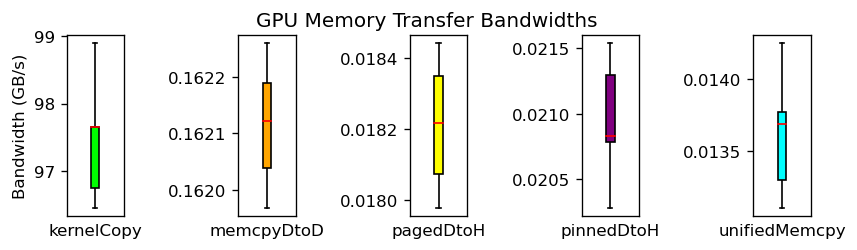

In [4]:
# Create a plot with a sub-boxplot for each transfer type
fig, axes = plt.subplots(1,5, figsize=(8,2), dpi=120)

axes[0].set_ylabel("Bandwidth (GB/s)")

# Create each boxplot in its own dedicated plot and color
colors = ["lime", "orange", "yellow", "purple", "cyan"]
for i, col in enumerate(bandwidths.columns):
    axes[i].boxplot(x=bandwidths[col], patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='red'), showfliers=False)
    axes[i].set_xlabel(col)
    axes[i].set_xticks([])
    
plt.subplots_adjust(wspace=2)
plt.suptitle("GPU Memory Transfer Bandwidths")
    
plt.show()

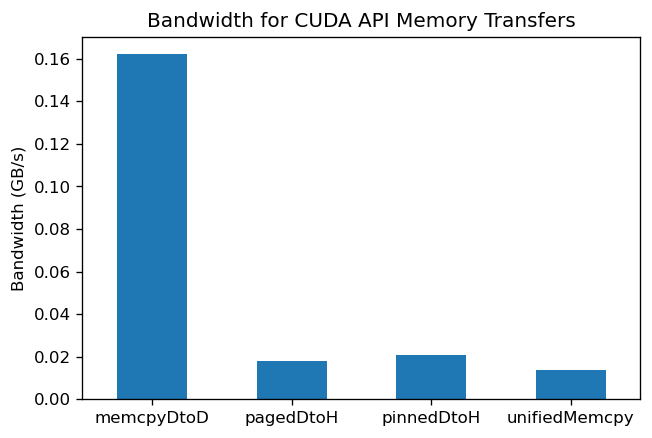

In [5]:
# Create a bar chart to more easily compare median bandwidths
# kernelCopy is omitted because you wouldn't be able to see the other bars otherwise
plt.figure(dpi=120)
bandwidths.iloc[:,1:].median().plot(kind="bar")
plt.title("Bandwidth for CUDA API Memory Transfers")
plt.xticks(rotation=0)
plt.ylabel("Bandwidth (GB/s)")
plt.show()